In [1]:
import numpy as np
import scipy
import pdb
from numba import jit,vectorize,float64, int64,types
import pandas as pd
import scipy.optimize as opt

In [2]:
def T_mat_template(kbar):
    kbar2 = 2**kbar
    A = np.zeros((kbar2,kbar2))
    for i in range(kbar2):
        for j in range(i,kbar2-i):
            A[i,j] = np.bitwise_xor(i,j)
    return(A)     

In [3]:
def transition_mat(A,inpt,kbar):
    b = inpt[0]
    gamma_kbar = inpt[2]
    gamma = np.zeros((kbar,1))
    gamma[0,0] = 1-(1-gamma_kbar)**(1/(b**(kbar-1)))
    for i in range(1,kbar):
        gamma[i,0] = 1-(1-gamma[0,0])**(b**(i))
    gamma = gamma*0.5
    gamma = np.c_[gamma,gamma]
    gamma[:,0] = 1 - gamma[:,1]
    kbar2 = 2**kbar
    prob = np.ones((kbar2,1))
    # all combination of probabilities from gamma_1*gamma_2*gamma_3, gamma_1*gamma_2*(1-gamma_3),...
    for i in range(kbar2):
        for m in range(kbar):
            prob[i,0] =prob[i,0] * gamma[kbar-m-1,
                np.unpackbits(np.array([i],dtype = np.uint8))[-(m+1)]]
    A_ = np.zeros((kbar2,kbar2))
    for i in range(kbar2):
        for m in range(kbar):
            prob[i,0] =prob[i,0]* gamma[kbar-m-1,
                np.unpackbits(np.array([i],dtype = np.uint8))[-(m+1)]]
    for i in range(2**(kbar-1)):
        for j in range(i,2**(kbar-1)):
            #pdb.set_trace()
            A_[kbar2-i-1,j] = prob[np.rint(kbar2 - A.copy()[i,j]-1).astype(int),0]
            A_[kbar2-j-1,i] = A_[kbar2-i-1,j]
            A_[j,kbar2-i-1] = A_[kbar2-i-1,j]
            A_[i,kbar2-j-1] = A_[kbar2-i-1,j]
            A_[i,j] = prob[np.rint(A.copy()[i,j]).astype(int),0]
            A_[j,i] = A_[i,j]
            A_[kbar2-j-1,kbar2-i-1] = A_[i,j]
            A_[kbar2-i-1,kbar2-j-1] = A_[i,j]
        
    return(A_)

In [4]:
def transition_mat_16(A,inpt,kbar):
    b = inpt[0]
    gamma_kbar = inpt[2]
    gamma = np.zeros((kbar,1))
    gamma[0,0] = 1-(1-gamma_kbar)**(1/(b**(kbar-1)))
    for i in range(1,kbar):
        gamma[i,0] = 1-(1-gamma[0,0])**(b**(i))
    gamma = gamma*0.5
    gamma = np.c_[gamma,gamma]
    gamma[:,0] = 1 - gamma[:,1]
    kbar2 = 2**kbar
    prob = np.ones((kbar2,1))
    # all combination of probabilities from gamma_1*gamma_2*gamma_3, gamma_1*gamma_2*(1-gamma_3),...
    for i in range(kbar2):
        for m in range(kbar):
            tmp = np.unpackbits(np.arange(i,i+1,dtype = np.uint16).view(np.uint8))
            tmp = np.append(tmp[8:],tmp[:8])
            prob[i,0] =prob[i,0] * gamma[kbar-m-1,tmp[-(m+1)]]
    A_ = np.zeros((kbar2,kbar2))
    for i in range(2**(kbar-1)):
        for j in range(i,2**(kbar-1)):
            #pdb.set_trace()
            A_[kbar2-i-1,j] = prob[np.rint(kbar2 - A.copy()[i,j]-1).astype(int),0]
            A_[kbar2-j-1,i] = A_[kbar2-i-1,j]
            A_[j,kbar2-i-1] = A_[kbar2-i-1,j]
            A_[i,kbar2-j-1] = A_[kbar2-i-1,j]
            A_[i,j] = prob[np.rint(A.copy()[i,j]).astype(int),0]
            A_[j,i] = A_[i,j]
            A_[kbar2-j-1,kbar2-i-1] = A_[i,j]
            A_[kbar2-i-1,kbar2-j-1] = A_[i,j]
        
    return(A_)

In [5]:
@jit(float64[:,:](float64[:,:],float64[:],int64))
def transition_mat_jit(A,inpt,kbar):
    b = inpt[0]
    gamma_kbar = inpt[2]
    gamma = np.zeros((kbar,1))
    gamma[0,0] = 1-(1-gamma_kbar)**(1/(b**(kbar-1)))
    for i in range(1,kbar):
        gamma[i,0] = 1-(1-gamma[0,0])**(b**(i))
    gamma = gamma*0.5
    gamma = np.c_[gamma,gamma]
    gamma[:,0] = 1 - gamma[:,1]
    kbar2 = 2**kbar
    prob = np.ones((kbar2,1))
    A_ = np.zeros((kbar2,kbar2))
    for i in range(kbar2):
        for m in range(kbar):
            prob[i,0] =prob[i,0]* gamma[kbar-m-1,
                np.unpackbits(np.array([i],dtype = np.uint8))[-(m+1)]]
    for i in range(2**(kbar-1)):
        for j in range(i,2**(kbar-1)):
            #pdb.set_trace()
            A_[kbar2-i-1,j] = prob[np.rint(kbar2 - A.copy()[i,j]-1).astype(int),0]
            A_[kbar2-j-1,i] = A_[kbar2-i-1,j]
            A_[j,kbar2-i-1] = A_[kbar2-i-1,j]
            A_[i,kbar2-j-1] = A_[kbar2-i-1,j]
            A_[i,j] = prob[np.rint(A.copy()[i,j]).astype(int),0]
            A_[j,i] = A_[i,j]
            A_[kbar2-j-1,kbar2-i-1] = A_[i,j]
            A_[kbar2-i-1,kbar2-j-1] = A_[i,j]
        
    return(A_)


In [6]:
def transition_mat_new(inpt,kbar):
    b = inpt[0]
    gamma_kbar = inpt[2]
    gamma = np.zeros((kbar,1))
    gamma[0,0] = 1-(1-gamma_kbar)**(1/(b**(kbar-1)))
    for i in range(1,kbar):
        gamma[i,0] = 1-(1-gamma[0,0])**(b**(i))
    gamma = gamma*0.5
    gamma = np.c_[gamma,gamma]
    gamma[:,0] = 1 - gamma[:,1]
    kbar2 = 2**kbar
    prob = np.ones(kbar2)
    # all combination of probabilities from gamma_1*gamma_2*gamma_3, gamma_1*gamma_2*(1-gamma_3),...
    for i in range(kbar2):
        for m in range(kbar):
            tmp = np.unpackbits(np.arange(i,i+1,dtype = np.uint16).view(np.uint8))
            tmp = np.append(tmp[8:],tmp[:8])
            prob[i] =prob[i] * gamma[kbar-m-1,tmp[-(m+1)]]
    A = np.fromfunction(lambda i,j: prob[np.bitwise_xor(i,j)],
                          (kbar2,kbar2),dtype = np.uint16)                 
    return(A)

In [7]:
@jit(float64[:,:](float64[:],int64))
def transition_mat_new_jit(inpt,kbar):
    b = inpt[0]
    gamma_kbar = inpt[2]
    gamma = np.zeros((kbar,1))
    gamma[0,0] = 1-(1-gamma_kbar)**(1/(b**(kbar-1)))
    for i in range(1,kbar):
        gamma[i,0] = 1-(1-gamma[0,0])**(b**(i))
    gamma = gamma*0.5
    gamma = np.c_[gamma,gamma]
    gamma[:,0] = 1 - gamma[:,1]
    kbar2 = 2**kbar
    A = np.zeros((kbar2,kbar2))
    prob = np.ones(kbar2)
    # all combination of probabilities from gamma_1*gamma_2*gamma_3, gamma_1*gamma_2*(1-gamma_3),...
    for i in range(kbar2):
        for m in range(kbar):
            prob[i] =prob[i] * gamma[kbar-m-1,
                np.unpackbits(np.array([i],dtype = np.uint8))[-(m+1)]]
    for i in range(kbar2):
        for j in range(kbar2):
            A[i,j] = prob[np.bitwise_xor(i,j)]
    return(A)

In [8]:
A = [T_mat_template(i) for i in range(2,9)]

In [9]:
np.allclose(transition_mat(A[0],[3,1.5,0.5,3],2),transition_mat_jit(A[0],[3,1.5,0.5,3],2),
            transition_mat_new_jit([3,1.5,0.5,3],2),transition_mat_new([3,1.5,0.5,3],2))

True

In [10]:
import time

times = np.zeros((4,len(A)))
for i,v in enumerate(A):
    start = time.time()
    transition_mat(v,np.array([3,1.5,0.5,3]),i+2)
    end = time.time()
    times[0,i] = end-start
    start = time.time()
    transition_mat_jit(v,np.array([3,1.5,0.5,3]),i+2)
    end = time.time()
    times[1,i] = end-start
    start = time.time()
    transition_mat_new(np.array([3,1.5,0.5,3]),i+2)
    end = time.time()
    times[2,i] = end-start
    start = time.time()
    transition_mat_new_jit(np.array([3,1.5,0.5,3]),i+2)
    end = time.time()
    times[3,i] = end-start

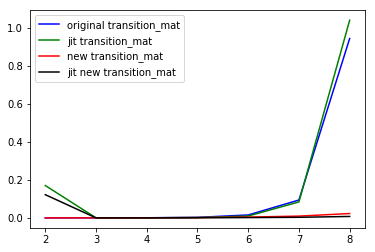

In [11]:
import matplotlib.pyplot as plt
plt.plot(np.arange(2,9),times[0,:],color = "blue",label = "original transition_mat")
plt.plot(np.arange(2,9),times[1,:],color = "green",label = "jit transition_mat")
plt.plot(np.arange(2,9),times[2,:],color = "red",label = "new transition_mat")
plt.plot(np.arange(2,9),times[3,:],color = "black",label = "jit new transition_mat")
plt.legend(loc='upper left')
plt.show()

In [12]:
def gofm(inpt,kbar):
    """
    A function that calculates all the possible volatility states
    """
    m0 = inpt[1]
    m1 = 2-m0
    kbar2 = 2**kbar
    g_m1 = np.arange(kbar2)
    g_m = np.zeros(kbar2)
    
    for i in range(kbar2):
        g =1
        for j in range(kbar):
            if np.bitwise_and(g_m1[i],(2**j))!=0:
                g = g*m1
            else:
                g = g*m0
        g_m[i] = g
    return(np.sqrt(g_m))

In [13]:
@jit(float64(float64,int64,float64[:,:],float64[:,:],float64[:]))
#estim_flag= list
#input = double
def MSM_like_init(inpt,kbar,data,A_template,estim_flag):
    inpt = [estim_flag[0],inpt,estim_flag[1],estim_flag[2]]
    sigma = inpt[3]/np.sqrt(252)
    k2 = 2**kbar
    A = transition_mat(A_template.copy(),inpt,kbar)
    g_m = gofm(inpt,kbar)
    T = len(data)
    pi_mat = np.zeros((T+1,k2))
    LLs = np.zeros(T)
    pi_mat[0,:] = (1/k2)*np.ones((1,k2))
    """
    Likelihood Algorithm
    """
    pa = (2*np.pi)**(-0.5)
    s = sigma*g_m
    w_t = data 
    w_t = pa*np.exp(-0.5*((w_t/s)**2))/s
    w_t = w_t + 1e-16

    for t in range(T):
        
        piA = np.dot(pi_mat[t,:],A)
        C = (w_t[t,:]*piA)
        ft = np.sum(C) # log
        if np.isclose(ft,0):
            pi_mat[t+1,1]=1
        else:
            pi_mat[t+1,:] = C/ft
        LLs[t] = np.log(np.dot(w_t[t,:],piA))
        
    LL = -np.sum(LLs)
    if np.any(np.isinf(LLs)):
        print("Log-likelihood is inf. Probably due to all zeros in pi_mat.")
    return (LL)

In [14]:
def MSM_likelihood(inpt,kbar,data):        
    sigma = inpt[3]/np.sqrt(252)
    k2 = 2**kbar
    A = transition_mat_new(inpt,kbar)
    g_m = gofm(inpt,kbar)
    T = len(data)
    pi_mat = np.zeros((T+1,k2))
    LLs = np.zeros(T)
    pi_mat[0,:] = (1/k2)*np.ones((1,k2))
    """
    Likelihood Algorithm
    """
    pa = (2*np.pi)**(-0.5)
    s = sigma*g_m
    w_t = data 
    w_t = pa*np.exp(-0.5*((w_t/s)**2))/s
    w_t = w_t + 1e-16

    for t in range(T):
        
        piA = np.dot(pi_mat[t,:],A)
        C = (w_t[t,:]*piA)
        ft = np.sum(C) # log
        if np.isclose(ft,0):
            pi_mat[t+1,1]=1
        else:
            pi_mat[t+1,:] = C/ft
        LLs[t] = np.log(np.dot(w_t[t,:],piA))
        
    LL = -np.sum(LLs)
    if np.any(np.isinf(LLs)):
        print("Log-likelihood is inf. Probably due to all zeros in pi_mat.")
    else:
        return(LL,LLs)

In [15]:
def MSM_starting_values(data,startingvals,kbar,A_template):
    if startingvals is None:
        print("No starting values entered: Using grid-search")

        b = np.array([1.5,3,6,20])
        lb = len(b)
        g = np.array([.1,.5,.9])
        lg = len(g)
        sigma = np.std(data)*np.sqrt(252)
        output_parameters = np.zeros(((lb*lg),3))
        LLs = np.zeros((lb*lg))
        m0_lower = 1.2
        m0_upper = 1.8
        idx = 0
        for i in range(lb):
            for j in range(lg):
                xopt,fval,ierr,numfunc = opt.fminbound(MSM_likelihood_init,
                                                 x1 = m0_lower,x2 = m0_upper,xtol = 1e-3,
                                                 args = (kbar,data,A_template,[b[i],g[j],sigma]),full_output = True)
                m0,LL = xopt,fval
                output_parameters[idx,:] = b[i],m0,g[j]
                LLs[idx] = LL
                idx +=1
        idx = np.argsort(LLs)
        LLs = np.sort(LLs)
        startingvals = output_parameters[idx[0],:].tolist()+[sigma]
        output_parameters = output_parameters[idx,:]
        return(startingvals,LLs,output_parameters)

In [16]:
def MSM_modified(data,kbar,startingvals):
        A_template = T_mat_template(kbar)
        startingvals, LLs,ordered_parameters = MSM_starting_values(data,startingvals,kbar,A_template)
        bnds = ((1,50),(1,1.99),(1e-3,0.999999),(1e-4,5))
        minimizer_kwargs = dict(method = "L-BFGS-B",bounds = bnds,args = (kbar,dat,A_template,None))
        res = opt.basinhopping(MSM_likelihood,x0 = startingvals,minimizer_kwargs = minimizer_kwargs,niter = 3)
        parameters,LL,niters,output = res.x,res.fun,res.nit,res.message
        LL, LLs = MSM_likelihood(parameters,kbar,data,A_template,None,2)
        LL = -LL
        
        return(LL,LLs,parameters)

In [17]:
dat = pd.read_csv("data_demo.csv",header = None)
dat = np.array(dat)

In [18]:
def MSM_likelihood_old(inpt,kbar,data,A_template):      
    sigma = inpt[3]/np.sqrt(252)
    k2 = 2**kbar
    A = transition_mat_16(A_template.copy(),inpt,kbar)
    g_m = gofm(inpt,kbar)
    T = len(data)
    pi_mat = np.zeros((T+1,k2))
    LLs = np.zeros(T)
    pi_mat[0,:] = (1/k2)*np.ones((1,k2))
    """
    Likelihood Algorithm
    """
    pa = (2*np.pi)**(-0.5)
    s = sigma*g_m
    w_t = data 
    w_t = pa*np.exp(-0.5*((w_t/s)**2))/s
    w_t = w_t + 1e-16

    for t in range(T):
        
        piA = np.dot(pi_mat[t,:],A)
        C = (w_t[t,:]*piA)
        ft = np.sum(C) # log
        if np.isclose(ft,0):
            pi_mat[t+1,1]=1
        else:
            pi_mat[t+1,:] = C/ft
        LLs[t] = np.log(np.dot(w_t[t,:],piA))
        
    LL = -np.sum(LLs)
    if np.any(np.isinf(LLs)):
        print("Log-likelihood is inf. Probably due to all zeros in pi_mat.")
    else:
        return(LL,LLs)

In [19]:
A = [T_mat_template(i) for i in range(2,11)]

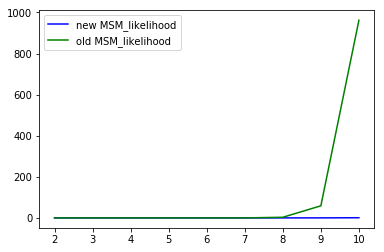

In [20]:
times = np.zeros((2,len(A)))
for i,v in enumerate(A):
    start = time.time()
    MSM_likelihood([3,1.5,0.5,3],i+2,dat)
    end = time.time()
    times[0,i] = end-start
    start = time.time()
    MSM_likelihood_old([3,1.5,0.5,3],i+2,dat,v)
    end = time.time()
    times[1,i] = end-start
plt.plot(np.arange(2,11),times[0,:],color = "blue",label = "new MSM_likelihood")
plt.plot(np.arange(2,11),times[1,:],color = "green",label = "old MSM_likelihood")
plt.legend(loc='upper left')
plt.show()

In [21]:
%time LL_,LLs_ = MSM_likelihood([3,1.5,0.5,3],10,dat)
%time LL,LLs = MSM_likelihood_old([3,1.5,0.5,3],10,dat,A[8])

CPU times: user 1.9 s, sys: 74.7 ms, total: 1.97 s
Wall time: 1.47 s
CPU times: user 9min 14s, sys: 6min 41s, total: 15min 56s
Wall time: 16min 24s


In [22]:
np.allclose(LL,LL_)

True

In [23]:
np.allclose(LLs_,LLs)

True

In [75]:
class memoize(dict):
    def __init__(self, func):
        self.func = func

    def __call__(self, *args):
        return self[args]

    def __missing__(self, key):
        result = self[key] = self.func(*key)
        return result

In [76]:
@memoize
def transition_prob(inpt,state_t,kbar):
    b = inpt[0]
    gamma_kbar = inpt[2]
    gamma = np.zeros((kbar,1))
    gamma[0,0] = 1-(1-gamma_kbar)**(1/(b**(kbar-1)))
    for i in range(1,kbar):
        gamma[i,0] = 1-(1-gamma[0,0])**(b**(i))
    gamma = gamma*0.5
    gamma = np.c_[gamma,gamma]
    gamma[:,0] = 1 - gamma[:,1]
    kbar2 = 2**kbar
    prob = np.ones(kbar2)
    # all combination of probabilities from gamma_1*gamma_2*gamma_3, gamma_1*gamma_2*(1-gamma_3),...
    for i in range(kbar2):
        for m in range(kbar):
            tmp = np.unpackbits(np.arange(i,i+1,dtype = np.uint16).view(np.uint8))
            tmp = np.append(tmp[8:],tmp[:8])
            prob[i] =prob[i] * gamma[kbar-m-1,tmp[-(m+1)]]
    A = np.fromfunction(lambda i,j: prob[np.bitwise_xor(np.uint16(state_t),j)],
                          (1,kbar2),dtype = np.uint16)                 
    return(A)

In [96]:
def particle_filter_prediction(inpt,kbar,data,B,n_steps,particles =None,weights = None):
    g_m = gofm(inpt,kbar)
    Ms = np.arange(len(g_m))
    sigma = inpt[3]/np.sqrt(252)
    M_pred = np.zeros((n_steps+1,B))
    pred_means = np.zeros(n_steps)
    pred_vars = np.zeros(n_steps)
    # check if particles are None or given
    if hasattr(particles,"__len__"):
        M_pred[0,:] = particles
    else:
        # no particles given so will simulate from time 1to t with data
        k2 = 2**kbar
        T = len(data)
        M_mat = np.zeros((T,B))
        pa = (2*np.pi)**(-0.5)
        s = sigma*g_m
        w_t = data 
        w_t = pa*np.exp(-0.5*((w_t/s)**2))/s
        w_t = w_t + 1e-16

        LLs = np.zeros(T-1)
        M_mat[0,:] = np.random.choice(Ms, size=B, replace=True, p=(1/k2)*np.ones(k2))

        for i in range(T-1):
            M_temp = np.zeros(B)
            ws = np.zeros(B)
            for j,val in enumerate(M_mat[i,:]):
                #pdb.set_trace()
                probs = transition_prob(inpt,val,kbar)[0]
                M_temp[j] = np.random.choice(Ms,size = 1,p = probs)
            for k,val in enumerate(M_temp):
                ws[k] = w_t[i+1,val.astype(int)]/np.sum(w_t[i+1,M_temp.astype(int)])
            M_mat[i+1,:] = np.random.choice(M_temp,size = B,replace = True,p = ws)
            LLs[i] = np.mean(w_t[i+1,M_mat[i+1,:].astype(int)])
        M_pred[0,:] = M_mat[-1,:]
        weights = w_t[-1,:]
    #n step ahed prediction with particle filter
    for i in range(n_steps):
        for j,val in enumerate(M_pred[i,:]):
            probs = transition_prob(inpt,val,kbar)[0]
            M_pred[i+1,j] = np.random.choice(Ms,size = 1, p = probs)
        pred_particles = sigma*np.sqrt(g_m[M_pred[i+1,:].astype(int)])
        #pdb.set_trace()
        weights = weights[M_pred[i+1,:].astype(int)]
        weights = weights/np.sum(weights)
        pred_means[i] = np.average(pred_particles,weights=weights)
        pred_vars[i] = np.average((pred_particles-pred_means[i])**2,weights=weights)
    return(pred_means,pred_vars,M_pred)  

In [79]:
transition_mat_new([3,1.5,0.5,3],5)[10,:]

array([  9.40031023e-04,   3.13343674e-04,   8.17323529e-03,
         2.72441176e-03,   3.61809985e-05,   1.20603328e-05,
         3.14580909e-04,   1.04860303e-04,   7.32376392e-02,
         2.44125464e-02,   6.36775215e-01,   2.12258405e-01,
         2.81885475e-03,   9.39618250e-04,   2.45089391e-02,
         8.16964637e-03,   4.02207332e-06,   1.34069111e-06,
         3.49704964e-05,   1.16568321e-05,   1.54806198e-07,
         5.16020660e-08,   1.34598481e-06,   4.48661604e-07,
         3.13358971e-04,   1.04452990e-04,   2.72454476e-03,
         9.08181588e-04,   1.20609216e-05,   4.02030720e-06,
         1.04865422e-04,   3.49551407e-05])

In [99]:
particle_filter_prediction((3,1.5,0.5,3),5,dat[:-5],1000,5)

(array([ 0.09144482,  0.10552225,  0.1022879 ,  0.11814351,  0.10935828]),
 array([ 0.00029034,  0.00058513,  0.00053389,  0.00073107,  0.00084477]),
 array([[ 31.,  31.,  31., ...,  30.,  31.,  31.],
        [ 31.,  30.,  31., ...,  28.,  29.,  31.],
        [ 31.,  30.,  31., ...,  28.,  29.,  30.],
        [ 31.,  31.,  30., ...,  30.,  29.,  28.],
        [ 31.,  31.,  30., ...,  30.,  28.,  28.],
        [ 31.,  31.,  31., ...,  31.,  28.,  28.]]))

In [100]:
dat[-5:]

array([[ 0.00508014],
       [-0.00726191],
       [ 0.00502422],
       [ 0.02150801],
       [ 0.01572753]])